Retrieve SEVERITYCODE as a dependent variable and other features which we will use as independent variables.(I deleted the code to read the csv file because it includes my IBM credential.)

In [3]:
df_1 = df_data_1.loc[:,["SEVERITYCODE","ADDRTYPE","INCDTTM","JUNCTIONTYPE","INATTENTIONIND","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND","PEDROWNOTGRNT","SPEEDING"]]

Remove the cases by human factors from df_1. For example, we leave the cases that "inattentionind" is not equal to yes. 

In [4]:
df_2 = df_1[(df_1["INATTENTIONIND"] != "Y") & (df_1["UNDERINFL"] != "Y") & (df_1["UNDERINFL"] != "1") & (df_1["PEDROWNOTGRNT"] != "Y") & (df_1["SPEEDING"] != "Y") ]

In [5]:
df_3 = df_2.loc[:,["SEVERITYCODE","ADDRTYPE","JUNCTIONTYPE","WEATHER","ROADCOND","LIGHTCOND"]]
df_3.head()

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,2,Intersection,At Intersection (intersection related),Overcast,Wet,Daylight
1,1,Block,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On
2,1,Block,Mid-Block (not related to intersection),Overcast,Dry,Daylight
3,1,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight
4,2,Intersection,At Intersection (intersection related),Raining,Wet,Daylight


Drop NaN data from df_3 to improve the accuracy.

In [6]:
df_4 = df_3.dropna(how='any')

Drop "Unknown" and "Other" cases from df_4.

In [7]:
df_5 = df_4[(df_4["JUNCTIONTYPE"]  != "Unknown") & (df_4["WEATHER"]  != "Unknown") & (df_4["WEATHER"]  != "Other") & (df_4["ROADCOND"]  != "Unknown") & (df_4["ROADCOND"]  != "Other") & (df_4["ROADCOND"]  != "Oil") & (df_4["LIGHTCOND"]  != "Unknown") & (df_4["LIGHTCOND"]  != "Other") & (df_4["LIGHTCOND"]  != "Dark - Unknown Lighting")]

Confirm the number of columns and rows.

In [8]:
df_5.shape

(120058, 6)

Convert categorical variables into indicator variables.

In [9]:
df_dummy = pd.get_dummies(df_5[["ADDRTYPE","JUNCTIONTYPE","WEATHER","ROADCOND","LIGHTCOND"]])
df_dummy.head()

,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,JUNCTIONTYPE_At Intersection (but not related to intersection),JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),JUNCTIONTYPE_Ramp Junction,WEATHER_Blowing Sand/Dirt,...,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


Transforme severity2 to “1” and severity1 to “0”.

In [10]:
df_dummy["SEVERITY"] = df_5["SEVERITYCODE"].map(lambda x: 1 if x == 2 else 0)

Split data into train data and test data.

In [11]:
from sklearn.model_selection import train_test_split

X = df_dummy.drop("SEVERITY", axis = 1)
y = df_dummy["SEVERITY"]

X_trainDT, X_testDT, y_trainDT, y_testDT = train_test_split( X, y, test_size=0.2, random_state=4)

Model1 : Decision Tree without balanced

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

drugTree = DecisionTreeClassifier(criterion="entropy")

param_grid = {'max_depth' : range(2,11)}

cv =GridSearchCV(drugTree, param_grid = param_grid, cv =10)
cv.fit(X_trainDT,y_trainDT)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': range(2, 11)})

In [13]:
cv.best_params_

{'max_depth': 2}

In [14]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 2)
drugTree.fit(X_trainDT,y_trainDT)

y_predDT = drugTree.predict(X_testDT)

print("accuracy(train) : {:.3f}" .format(drugTree.score(X_trainDT, y_trainDT)))
print("accuracy(test) : {:.3f}" .format(drugTree.score(X_testDT, y_testDT)))

accuracy(train) : 0.701
accuracy(test) : 0.704


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_testDT, y_predDT))

              precision    recall  f1-score   support

           0       0.70      1.00      0.83     16915
           1       0.00      0.00      0.00      7097

    accuracy                           0.70     24012
   macro avg       0.35      0.50      0.41     24012
weighted avg       0.50      0.70      0.58     24012



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model2 : Deceision Tree with balanced.

In [16]:
drugTree = DecisionTreeClassifier(class_weight='balanced', criterion="entropy")

param_grid = {'max_depth' : range(2,11)}

cv =GridSearchCV(drugTree, param_grid = param_grid, cv =10)
cv.fit(X_trainDT,y_trainDT)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='entropy'),
             param_grid={'max_depth': range(2, 11)})

In [17]:
cv.best_params_

{'max_depth': 2}

In [18]:
drugTree = DecisionTreeClassifier(class_weight='balanced', criterion="entropy", max_depth = 2)
drugTree.fit(X_trainDT,y_trainDT)

y_predDT = drugTree.predict(X_testDT)

print("accuracy(train) : {:.3f}" .format(drugTree.score(X_trainDT, y_trainDT)))
print("accuracy(test) : {:.3f}" .format(drugTree.score(X_testDT, y_testDT)))

accuracy(train) : 0.627
accuracy(test) : 0.631


In [19]:
print(classification_report(y_testDT, y_predDT))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72     16915
           1       0.40      0.52      0.45      7097

    accuracy                           0.63     24012
   macro avg       0.59      0.60      0.59     24012
weighted avg       0.66      0.63      0.64     24012



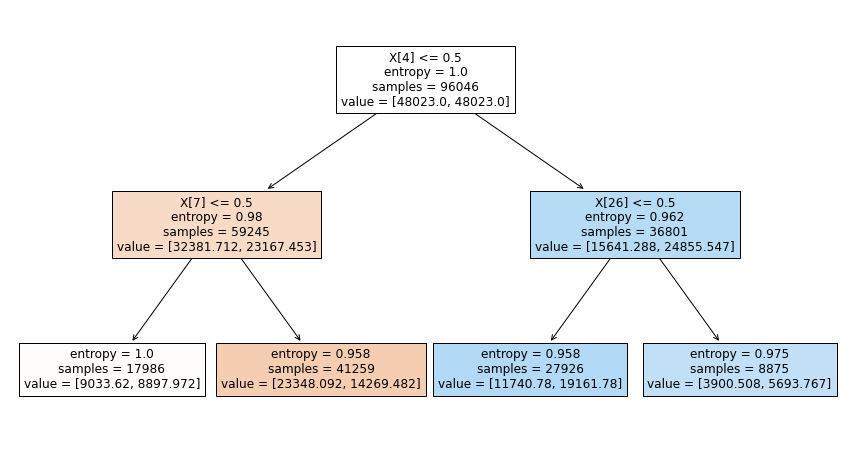

In [20]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()
plot_tree(drugTree, filled=True);

Model3 : Random Forest without balanced

In [21]:
X_trainRF, X_testRF, y_trainRF, y_testRF = train_test_split( X, y, test_size=0.2, random_state=4)

Parameters : max_depth=2, n_estimators=50

In [22]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=2, n_estimators=50, criterion="entropy",random_state=4)
random_forest.fit(X_trainRF, y_trainRF)

y_predRF = random_forest.predict(X_testRF)

trainaccuracy_random_forest = random_forest.score(X_trainRF, y_trainRF)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest))

TrainAccuracy: 0.7005497365845532


In [23]:
print(classification_report(y_testRF, y_predRF))

              precision    recall  f1-score   support

           0       0.70      1.00      0.83     16915
           1       0.00      0.00      0.00      7097

    accuracy                           0.70     24012
   macro avg       0.35      0.50      0.41     24012
weighted avg       0.50      0.70      0.58     24012



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model4 : Random Forest with balanced

In [24]:
random_forest = RandomForestClassifier(class_weight='balanced_subsample', max_depth=2, n_estimators=50,criterion="entropy", random_state=4)
random_forest.fit(X_trainRF, y_trainRF)

y_predRF = random_forest.predict(X_testRF)

trainaccuracy_random_forest = random_forest.score(X_trainRF, y_trainRF)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest))

TrainAccuracy: 0.6232950877704433


In [25]:
print(classification_report(y_testRF, y_predRF))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72     16915
           1       0.40      0.53      0.46      7097

    accuracy                           0.63     24012
   macro avg       0.59      0.60      0.59     24012
weighted avg       0.66      0.63      0.64     24012



In [26]:
importance = pd.DataFrame({ "Variable":X_trainRF.columns, "Importance" :random_forest.feature_importances_})
importance

,Variable,Importance
0,ADDRTYPE_Alley,0.000138
1,ADDRTYPE_Block,0.263467
2,ADDRTYPE_Intersection,0.197743
3,JUNCTIONTYPE_At Intersection (but not related ...,0.000394
4,JUNCTIONTYPE_At Intersection (intersection rel...,0.121970
5,JUNCTIONTYPE_Driveway Junction,0.006227
6,JUNCTIONTYPE_Mid-Block (but intersection related),0.008598
7,JUNCTIONTYPE_Mid-Block (not related to interse...,0.269645
8,JUNCTIONTYPE_Ramp Junction,0.000000
9,WEATHER_Blowing Sand/Dirt,0.000000


Visualization

In [27]:
import matplotlib.style
import matplotlib.pyplot as plt

matplotlib.style.use("ggplot")

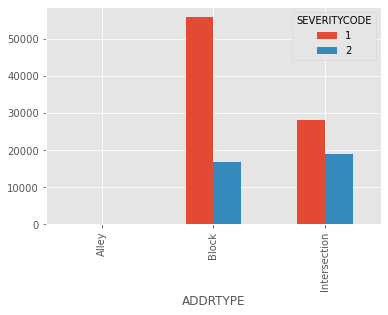

In [28]:
df_5.groupby("ADDRTYPE")["SEVERITYCODE"].value_counts().unstack().plot.bar()

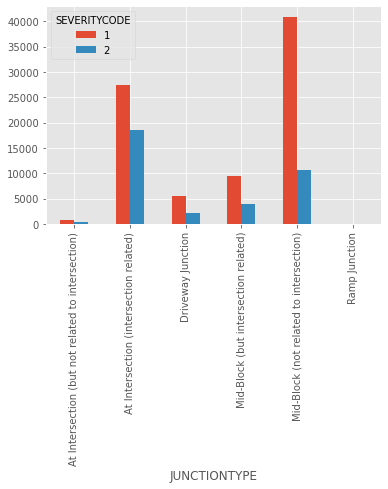

In [29]:
df_5.groupby("JUNCTIONTYPE")["SEVERITYCODE"].value_counts().unstack().plot.bar()

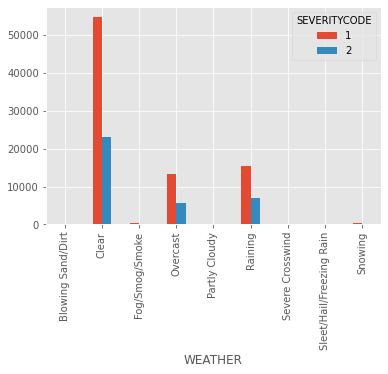

In [30]:
df_5.groupby("WEATHER")["SEVERITYCODE"].value_counts().unstack().plot.bar()

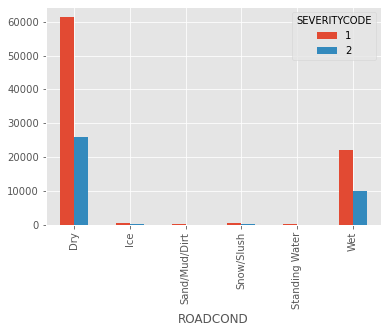

In [31]:
df_5.groupby("ROADCOND")["SEVERITYCODE"].value_counts().unstack().plot.bar()

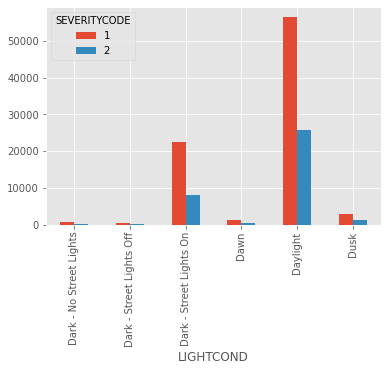

In [32]:
df_5.groupby("LIGHTCOND")["SEVERITYCODE"].value_counts().unstack().plot.bar()

In [33]:
df_1.head(25)

,SEVERITYCODE,ADDRTYPE,INCDTTM,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING
0,2,Intersection,3/27/2013 2:54:00 PM,At Intersection (intersection related),NaN,N,Overcast,Wet,Daylight,NaN,NaN
1,1,Block,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN
2,1,Block,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),NaN,0,Overcast,Dry,Daylight,NaN,NaN
3,1,Block,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),NaN,N,Clear,Dry,Daylight,NaN,NaN
4,2,Intersection,1/28/2004 8:04:00 AM,At Intersection (intersection related),NaN,0,Raining,Wet,Daylight,NaN,NaN
5,1,Intersection,4/20/2019 5:42:00 PM,At Intersection (intersection related),NaN,N,Clear,Dry,Daylight,NaN,NaN
6,1,Intersection,12/9/2008,At Intersection (intersection related),NaN,0,Raining,Wet,Daylight,NaN,NaN
7,2,Intersection,4/15/2020 5:47:00 PM,At Intersection (intersection related),NaN,N,Clear,Dry,Daylight,NaN,NaN
8,1,Block,6/15/2006 1:00:00 PM,Mid-Block (not related to intersection),NaN,0,Clear,Dry,Daylight,NaN,NaN
9,2,Intersection,3/20/2006 3:49:00 PM,At Intersection (intersection related),NaN,0,Clear,Dry,Daylight,NaN,NaN


In [34]:
df_2.head(25)

,SEVERITYCODE,ADDRTYPE,INCDTTM,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING
0,2,Intersection,3/27/2013 2:54:00 PM,At Intersection (intersection related),NaN,N,Overcast,Wet,Daylight,NaN,NaN
1,1,Block,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN
2,1,Block,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),NaN,0,Overcast,Dry,Daylight,NaN,NaN
3,1,Block,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),NaN,N,Clear,Dry,Daylight,NaN,NaN
4,2,Intersection,1/28/2004 8:04:00 AM,At Intersection (intersection related),NaN,0,Raining,Wet,Daylight,NaN,NaN
5,1,Intersection,4/20/2019 5:42:00 PM,At Intersection (intersection related),NaN,N,Clear,Dry,Daylight,NaN,NaN
6,1,Intersection,12/9/2008,At Intersection (intersection related),NaN,0,Raining,Wet,Daylight,NaN,NaN
7,2,Intersection,4/15/2020 5:47:00 PM,At Intersection (intersection related),NaN,N,Clear,Dry,Daylight,NaN,NaN
8,1,Block,6/15/2006 1:00:00 PM,Mid-Block (not related to intersection),NaN,0,Clear,Dry,Daylight,NaN,NaN
9,2,Intersection,3/20/2006 3:49:00 PM,At Intersection (intersection related),NaN,0,Clear,Dry,Daylight,NaN,NaN
